# Load Data

In [1]:
import json
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
from scipy.linalg import inv
from torch.optim import Adam

In [2]:
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]


# Encode Labels

In [3]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

# Tokenize our sentences and create Dataloaders

In [4]:
pretrained_model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
max_length = 37 
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)

# Define functions to encode our sentences

In [8]:
transformer_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)
def encode_sentences(model, sentences):
    sentence_embeddings = []

    for sentence in sentences:
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move input to GPU if available

        with torch.no_grad():
            model_output = transformer_model(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)
        sentence_embeddings.append(pooled_output.cpu().numpy())

    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np

In [9]:
train_embeddings = encode_sentences(transformer_model, train_sentences)
val_embeddings = encode_sentences(transformer_model, val_sentences)
test_embeddings = encode_sentences(transformer_model, test_sentences)
oos_train_embeddings = encode_sentences(transformer_model, oos_train_sentences)
oos_val_embeddings = encode_sentences(transformer_model, oos_val_sentences)
oos_test_embeddings = encode_sentences(transformer_model, oos_test_sentences)

# Calculate means and covariance matrix

In [17]:
unique_intents = list(set(train_labels)) 
intent_means = {}
for intent in unique_intents:
    indices = [i for i, label in enumerate(train_labels) if label == intent]
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    intent_means[intent] = intent_mean

In [18]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

# Define our model

In [12]:
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model    
    def forward(self, input_ids, attention_mask):
        # Get the output from the transformer model
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Pool the outputs into a single sentence vector
        # You can use `transformer_output.last_hidden_state.mean(dim=1)` for mean pooling
        # or `transformer_output.last_hidden_state.max(dim=1).values` for max pooling
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values
        # Forward pass through the classifier layer
        return sentence_embedding

# Define Mahalanobis Loss

In [13]:
class MahalanobisDistanceLoss(nn.Module):
    def __init__(self, centroids, cov_inverse):
        super(MahalanobisDistanceLoss, self).__init__()
        self.centroids = {k: v.to(device) for k, v in centroids.items()}
        self.cov_inverse = cov_inverse.to(device)
        self.device = device

    def forward(self, predictions, labels):
        predictions = predictions.to(self.device)
        loss = 0

        for i in range(predictions.shape[0]):
            label = labels[i].item()
            centroid = self.centroids[label]  # Get the corresponding centroid

            diff = predictions[i] - centroid
            distance = torch.matmul(torch.matmul(diff, self.cov_inverse), diff.t())
            loss += distance.squeeze()  # Squeeze to remove extra dimensions

        return loss / predictions.shape[0]


In [14]:
centroids_tensor = {k: torch.tensor(v, dtype=torch.float32) for k, v in intent_means.items()}
cov_inverse_tensor = torch.tensor(cov_inverse, dtype=torch.float32)
loss_function = MahalanobisDistanceLoss(centroids_tensor, cov_inverse_tensor)

# Initiallize everything else we needed

In [16]:
pretrained_model_name = "distilroberta-base"
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
transformer_model.to(device)
model = TextClassifier(transformer_model, len(unique_intents))
optimizer = Adam(model.parameters(), lr=1e-3)
training_losses = []
validation_losses = []
batch_size= 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

NameError: name 'unique_intents' is not defined

In [208]:
num_epochs = 50

# Training Loop!!!

In [209]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

        optimizer.zero_grad()  # Zero the gradients
        predictions = model(input_ids, attention_mask)  # Forward pass
        loss = loss_function(predictions, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss) 

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            predictions = model(input_ids, attention_mask)  # Forward pass
            loss = loss_function(predictions, labels)  # Compute loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model, 'best_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs}: Lower validation loss found. Model saved.")
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5e}, Validation Loss: {avg_val_loss:.5e}")

RuntimeError: The size of tensor a (150) must match the size of tensor b (768) at non-singleton dimension 0

# Visuals

In [173]:
fine_model = torch.load("best_model.pth")
fine_model.eval()  # Put the model in evaluation mode
fine_model = fine_model.to(device)
test_embeddings = encode_sentences(fine_model, test_sentences)
oos_test_embeddings = encode_sentences(fine_model, oos_test_sentences)

In [174]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from scipy.spatial import distance
from sklearn.metrics import average_precision_score

In [175]:
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)

In [176]:
# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.1659555994128612

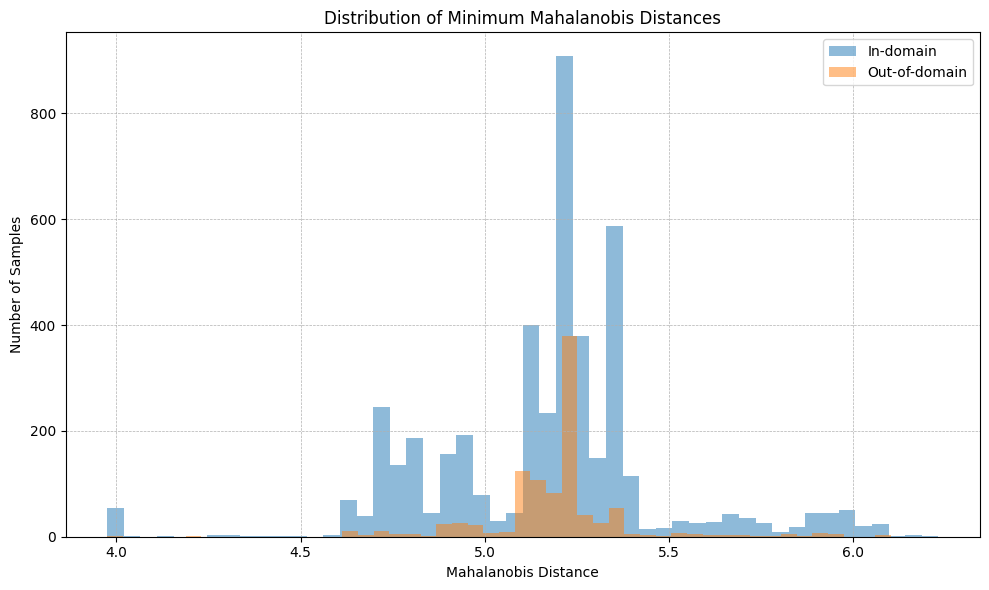

In [177]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()
